# Using tensorflow dataset from directory to load images

Notebook Color Scheme:


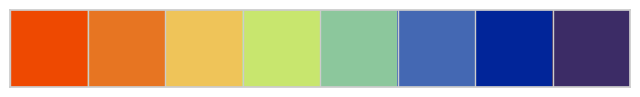

In [11]:
# standard imports
import os
import gc
import wandb
import time
import random
import math
import pathlib
from tqdm import tqdm
import warnings
import pandas as pd
import numpy as np

# ml imports
import tensorflow as tf

# plotting & settings
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from cycler import cycler

plt.rcParams.update({
    'font.size': 16, 
    'figure.figsize': (12,14)
})
sns.set_theme(style="whitegrid")

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
RANDOM_SEED = 42

# Custom colors
class clr:
    S = '\033[1m' + '\033[90m'
    E = '\033[0m'
    
my_colors = ["#EE4901", "#E77522", "#EFC459", "#C8E66E", "#8CC79C", "#4468B3", "#012599", "#3C2C66"]

print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [12]:
data_path = pathlib.Path("../data/numbers/train")

img_width, img_height = (32,32)

train_ds_ = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=RANDOM_SEED,
    image_size=(img_width, img_height),
    batch_size=32
    )

valid_ds_ = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=(img_width, img_height),
    batch_size=32
    )

Found 49314 files belonging to 10 classes.
Using 39452 files for training.
Found 49314 files belonging to 10 classes.
Using 9862 files for validation.


In [13]:
class_names = train_ds_.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Loaded dataset visualisation

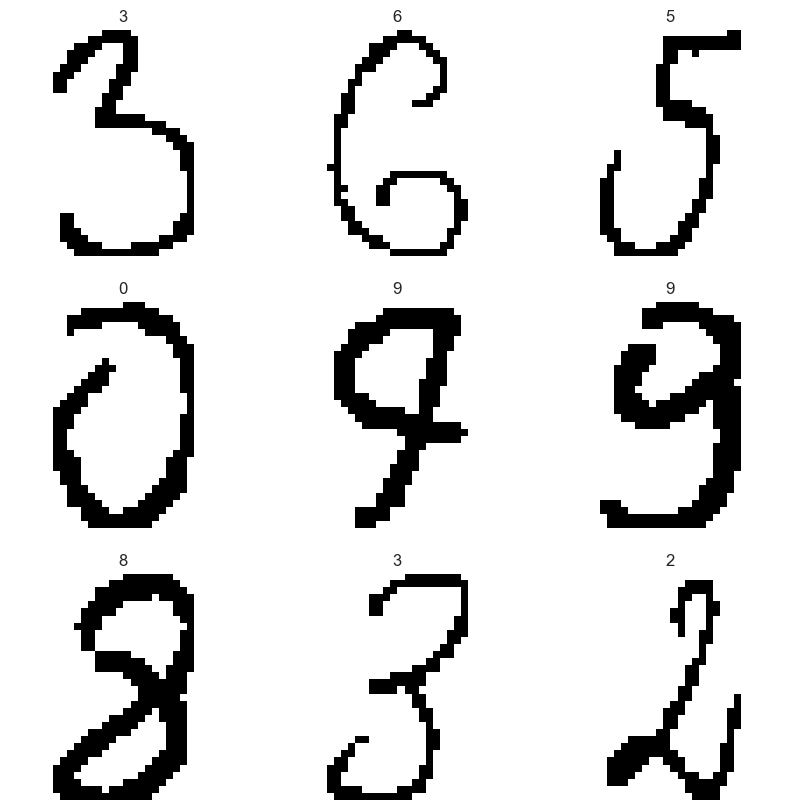

In [14]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for images, labels in train_ds_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [15]:
for image_batch, labels_batch in train_ds_:
  print(f"Input shape:  ", image_batch.shape)
  print(f"Labels shape: ", labels_batch.shape)
  break

Input shape:   (32, 32, 32, 3)
Labels shape:  (32,)


In [16]:
train_ds = (
    train_ds_
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_ds = (
    valid_ds_
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [17]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) # images must be normalized

0.0 255.0


2022-10-02 16:54:45.178383: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Basic convolutional model

Here we check our preprocessing and training steps if they are correct

In [18]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
num_epochs = 6

history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=num_epochs
)

Epoch 1/6


2022-10-02 16:54:46.227725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1233/1233 [==============================] - 6s 2ms/step - loss: 0.1654 - accuracy: 0.9486 - val_loss: 0.0677 - val_accuracy: 0.9808
Epoch 2/6
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0420 - accuracy: 0.9873 - val_loss: 0.0468 - val_accuracy: 0.9860
Epoch 3/6
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0268 - accuracy: 0.9918 - val_loss: 0.0482 - val_accuracy: 0.9868
Epoch 4/6
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0204 - accuracy: 0.9938 - val_loss: 0.0551 - val_accuracy: 0.9857
Epoch 5/6
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0153 - accuracy: 0.9953 - val_loss: 0.0526 - val_accuracy: 0.9885
Epoch 6/6
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0467 - val_accuracy: 0.9913


## Training history visualisation

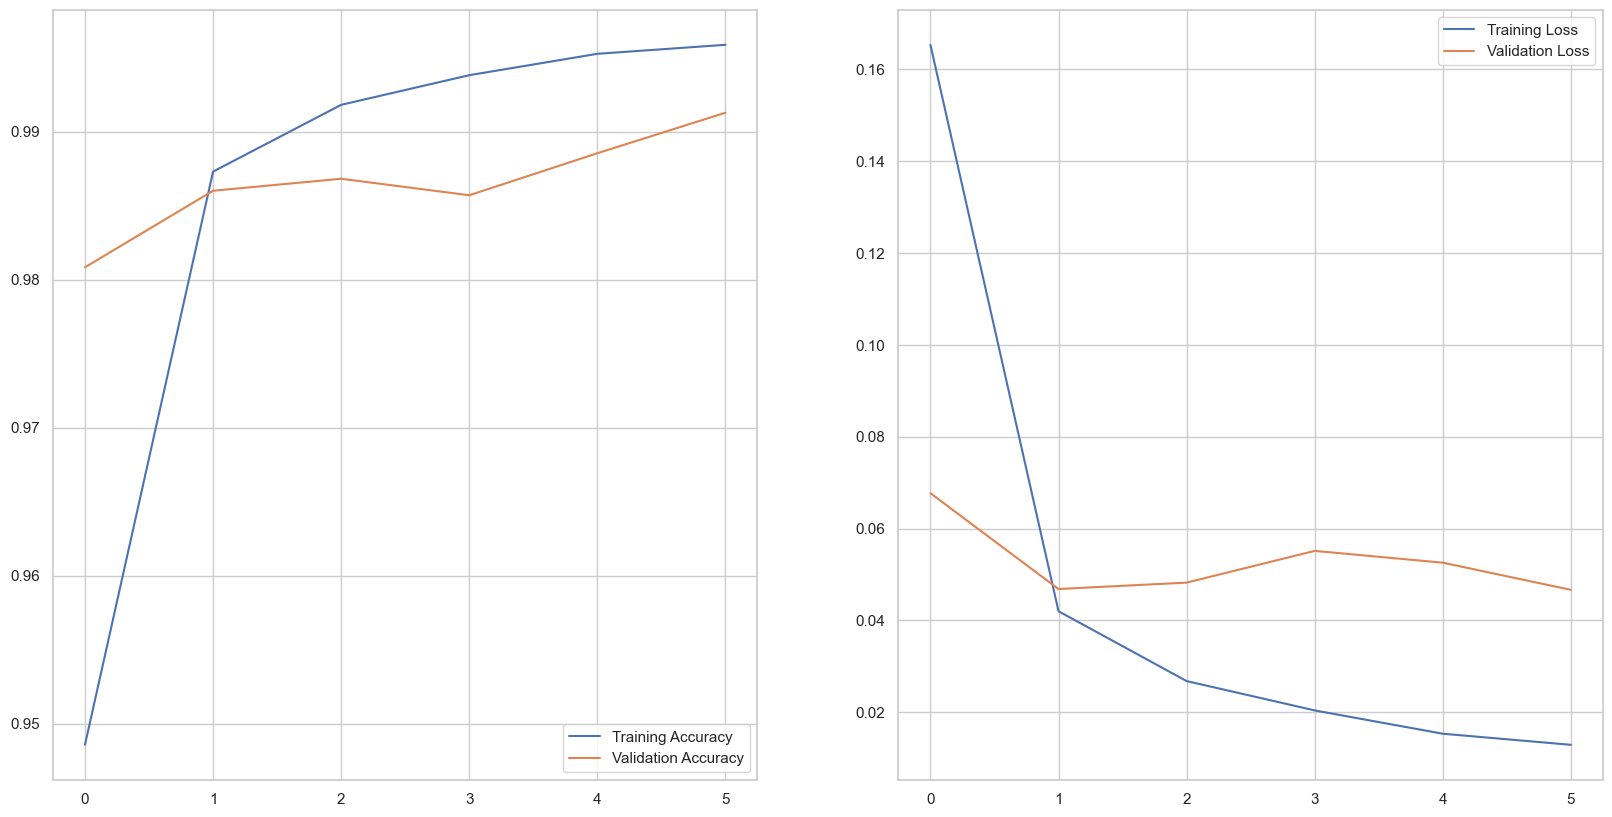

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(epochs_range, acc, label='Training Accuracy')
axes[0].plot(epochs_range, val_acc, label='Validation Accuracy')
axes[0].legend(loc='lower right')
#axes[0].title('Training and Validation Accuracy')

axes[1].plot(epochs_range, loss, label='Training Loss')
axes[1].plot(epochs_range, val_loss, label='Validation Loss')
axes[1].legend(loc='upper right')
#axes[1].title('Training and Validation Loss')

plt.show()